#   Step 1: Data Preprocessing & Loading 
##  Visualization of Images and Labels / Inserting Grayscale Conversion / Augmentation 

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, RandomFlip, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical

In [2]:
# Load the CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

In [3]:
# Check data dimensions
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


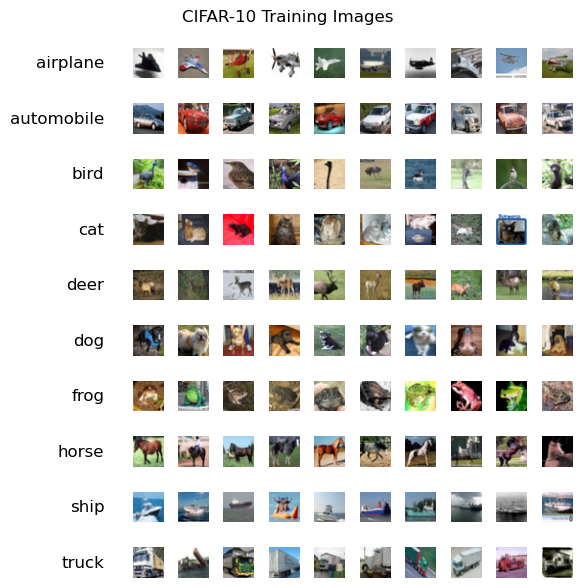

In [4]:
# Define a list with all the class labels for CIFAR-10
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Function to visualize color images from CIFAR-10 dataset with correct labeling
def visualize_color_images_with_labels(images, labels, classes, images_per_class=10, title="CIFAR-10 Images"):
    num_classes = len(classes)
    total_images = num_classes * images_per_class

    plt.figure(figsize=(6, 6))
    image_count = 0

    # Loop through class labels to pick images_per_class images per class
    for class_index, class_name in enumerate(classes):
        class_images = images[labels.flatten() == class_index][:images_per_class]

        # Loop through the images, arranging them dynamically
        for img in class_images:
            plt.subplot(num_classes, images_per_class, image_count + 1)
            plt.imshow(img)
            plt.axis('off')
            
            # Add class label to the left side of each row
            if image_count % images_per_class == 0:
                plt.text(-30, 32 // 2, class_name, rotation=0, size='large', va='center', ha='right')
            
            image_count += 1
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize color images from the CIFAR-10 training set
visualize_color_images_with_labels(x_train, y_train, classes, images_per_class=10, title="CIFAR-10 Training Images")


In [5]:
# Create augmentation layer for model (used further down)

data_augmentation = Sequential([
layers.RandomFlip("horizontal_and_vertical"),
layers.RandomRotation(0.2),
]) 


In [6]:
# Normalize the images to the range [0, 1]
x_train_normalized = x_train.astype('float32') / 255.0
x_test_normalized = x_test.astype('float32') / 255.0

print(x_train_normalized.shape)
print(x_test_normalized.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [7]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


# Step 2: Finetune and train model

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to categorical (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Load DenseNet121 with pre-trained ImageNet weights, excluding the top layer
# pooling='avg' applies global average pooling automatically
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(32, 32, 3), pooling='avg')

# Fine-tune the model: Unfreeze the last 20 layers of the DenseNet
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Add custom layers
x = base_model.output  # No need for additional GlobalAveragePooling2D
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)

# Output layer for CIFAR-10 (10 classes)
predictions = Dense(10, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model using SGD with momentum
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation (optional, but recommended for image classification tasks)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

# Apply data augmentation only to the training images, not labels
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset without augmentation
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

# Learning rate scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# Train the model
model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[reduce_lr])

# Make predictions using the model
predictions = model.predict(val_dataset)


29084464/29084464 [==============================] - 2s 0us/step
Epoch 1/20
1563/1563 [==============================] - 98s 56ms/step - loss: 1.2399 - accuracy: 0.5679 - val_loss: 1.0518 - val_accuracy: 0.6362 - lr: 0.0100
Epoch 2/20
1563/1563 [==============================] - 79s 50ms/step - loss: 1.0165 - accuracy: 0.6446 - val_loss: 1.0305 - val_accuracy: 0.6453 - lr: 0.0100
Epoch 3/20
1563/1563 [==============================] - 76s 49ms/step - loss: 0.9259 - accuracy: 0.6741 - val_loss: 0.9697 - val_accuracy: 0.6646 - lr: 0.0100
Epoch 4/20
1563/1563 [==============================] - 76s 49ms/step - loss: 0.8638 - accuracy: 0.6967 - val_loss: 0.9549 - val_accuracy: 0.6735 - lr: 0.0100
Epoch 5/20
1563/1563 [==============================] - 77s 49ms/step - loss: 0.8123 - accuracy: 0.7141 - val_loss: 0.9788 - val_accuracy: 0.6683 - lr: 0.0100
Epoch 6/20
1563/1563 [==============================] - 73s 47ms/step - loss: 0.7687 - accuracy: 0.7279 - val_loss: 0.9632 - val_accuracy: 0

# Step 3: Train model with more unfrozen layers

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to categorical (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Load DenseNet121 with pre-trained ImageNet weights, excluding the top layer
# pooling='avg' applies global average pooling automatically
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(32, 32, 3), pooling='avg')

# Fine-tune the model: Unfreeze the last 40 layers of the DenseNet
for layer in base_model.layers[:-40]:
    layer.trainable = False

# Add custom layers
x = base_model.output  # No need for additional GlobalAveragePooling2D
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)

# Output layer for CIFAR-10 (10 classes)
predictions = Dense(10, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model using SGD with momentum
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation (optional, but recommended for image classification tasks)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

# Apply data augmentation only to the training images, not labels
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset without augmentation
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

# Learning rate scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[reduce_lr])

# Make predictions using the model
predictions = model.predict(val_dataset)


Epoch 1/10
1563/1563 [==============================] - 94s 55ms/step - loss: 1.2229 - accuracy: 0.5743 - val_loss: 1.0209 - val_accuracy: 0.6479 - lr: 0.0100
Epoch 2/10
1563/1563 [==============================] - 82s 53ms/step - loss: 0.9950 - accuracy: 0.6502 - val_loss: 0.9708 - val_accuracy: 0.6636 - lr: 0.0100
Epoch 3/10
1563/1563 [==============================] - 82s 52ms/step - loss: 0.9030 - accuracy: 0.6842 - val_loss: 0.9551 - val_accuracy: 0.6728 - lr: 0.0100
Epoch 4/10
1563/1563 [==============================] - 82s 53ms/step - loss: 0.8370 - accuracy: 0.7066 - val_loss: 0.9401 - val_accuracy: 0.6776 - lr: 0.0100
Epoch 5/10
1563/1563 [==============================] - 82s 53ms/step - loss: 0.7863 - accuracy: 0.7226 - val_loss: 0.9504 - val_accuracy: 0.6781 - lr: 0.0100
Epoch 6/10
1563/1563 [==============================] - 81s 52ms/step - loss: 0.7371 - accuracy: 0.7382 - val_loss: 0.9588 - val_accuracy: 0.6775 - lr: 0.0100
Epoch 7/10
1563/1563 [========================

#  Step 4: Model Evaluation
## Evaluate the Model and Compute Metrics

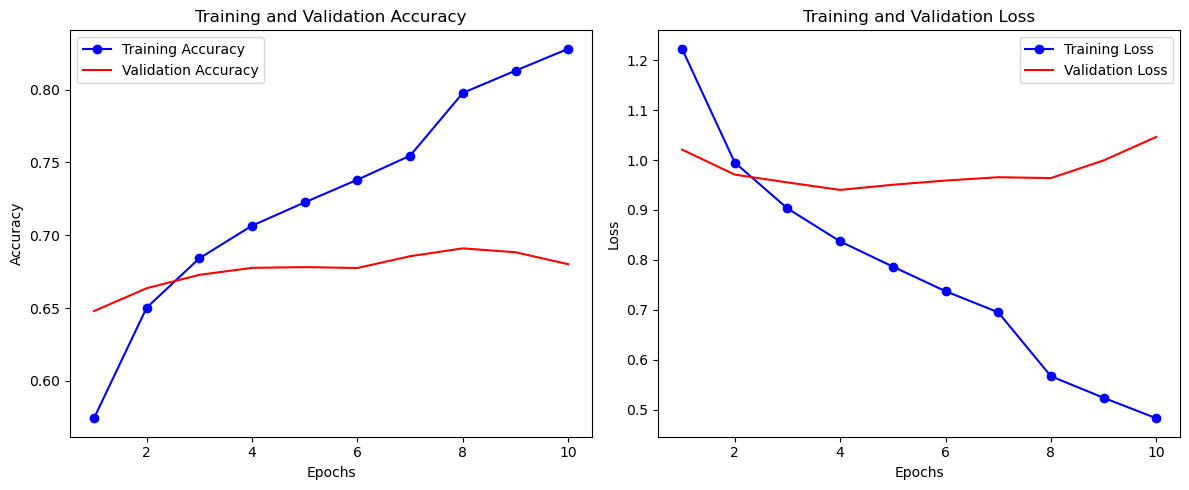

In [10]:

import matplotlib.pyplot as plt

# Extract values from the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Create a figure for accuracy and loss plots
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [24]:
# Make prediction
predictions = model.predict(x_test_normalized)

y_pred = np.argmax(predictions, axis=1)

313/313 [==============================] - 11s 34ms/step


In [27]:
# Convert one-hot encoded labels to integer labels
y_test_int = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_int, y_pred)
print(f"Test Accuracy: {accuracy}")

# Compute precision score, recall and F1
precision = precision_score(y_test_int, y_pred, average = "macro")
recall = recall_score(y_test_int, y_pred, average = "macro")
f1 = f1_score(y_test_int, y_pred, average = "macro")

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Test Accuracy: 0.6801
Precision: 0.6810223044588366
Recall: 0.6801
F1 Score: 0.6789286578512884


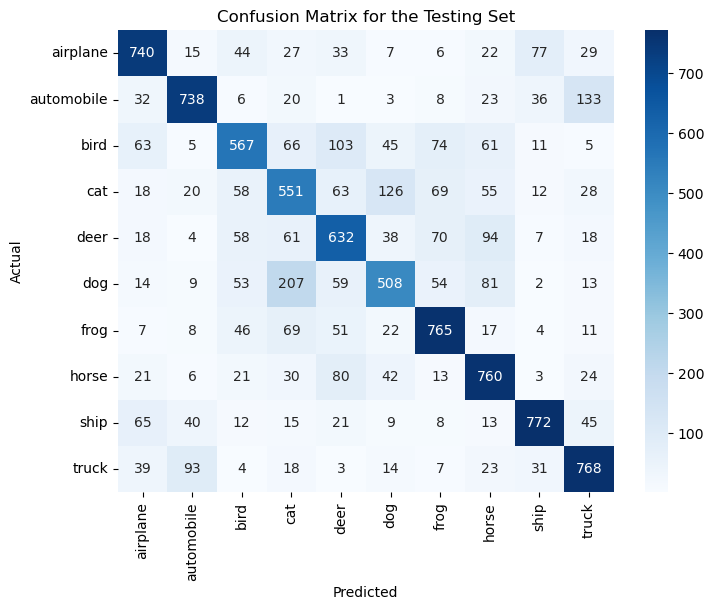

In [29]:
# Plot confusion matrix
cm = confusion_matrix(y_test_int, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels = classes, yticklabels = classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for the Testing Set')
plt.show()